In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics.pairwise import rbf_kernel

In [11]:
# Load Data
def load_spy_csv(path: str, date_col: str = 'Date') -> pd.DataFrame:
    df = pd.read_csv(path, parse_dates=[date_col])
    if 'Volume' in df.columns:
        df['Volume'] = df['Volume'].replace(',', '', regex=True).astype(float)
    df.sort_values(date_col, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [ ]:
# Functions to be used later
# Calculate EMA
def calculate_ema(prices, span):
    return pd.Series(prices).ewm(span=span, adjust=False).mean()

# Calculate RDP
def calculate_rdp(prices, n):
    prices = pd.Series(prices)
    return (prices - prices.shift(n)) / prices.shift(n) * 100

#Calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred)) ** 2))

# Limit outliers
def cap_outliers(series, k: float = 2, *, drop: bool = False):
    s = pd.Series(series).astype(float)
    lo, hi = s.mean() - k * s.std(), s.mean() + k * s.std()
    mask = (s < lo) | (s > hi)
    return s[~mask] if drop else s.clip(lo, hi)

# Scale to range [-0.9, 0.9]
def scale_to_range(series, low=-0.9, high=0.9):
    s = pd.Series(series).astype(float)
    mn, mx = s.min(), s.max()
    if mx == mn:
        return pd.Series(np.zeros_like(s), index=s.index)
    return low + (s - mn) * (high - low) / (mx - mn)

In [13]:
# Input and Output for the feature space
# Y
def calculate_targets(prices):
    ema3 = calculate_ema(prices, 3)
    y_raw = (ema3 - ema3.shift(5)) / ema3.shift(5) * 100
    y_clean = cap_outliers(y_raw)
    return scale_to_range(y_clean).dropna()

# X
def construct_input_features(prices):
    ema_hat15 = prices - calculate_ema(prices, 15)
    feats = pd.DataFrame({
        'x1': ema_hat15.shift(5),
        'x2': cap_outliers(calculate_rdp(prices, 5)).shift(5),
        'x3': cap_outliers(calculate_rdp(prices, 10)).shift(5),
        'x4': cap_outliers(calculate_rdp(prices, 15)).shift(5),
        'x5': cap_outliers(calculate_rdp(prices, 20)).shift(5)
    })
    # Scale each column to [‑0.9,0.9]
    for col in feats.columns:
        feats[col] = scale_to_range(feats[col])
    return feats.dropna()

In [14]:
# Split data into DS using walk-forward
# Train = 1,000, Validation/Testing = 200, walk forward 100 days betweene each DS
def create_walkforward_sets(prices: pd.Series,
                            train_len=1000, val_len=200, test_len=200,
                            step=100, num_sets=4):
    sets = []
    for i in range(num_sets):
        s = i * step
        sets.append({
            'name': f'DS-{i+1}',
            'train': prices.iloc[s: s + train_len],
            'val'  : prices.iloc[s + train_len: s + train_len + val_len],
            'test' : prices.iloc[s + train_len + val_len: s + train_len + val_len + test_len]
        })
    return sets

In [ ]:
# Histograms to show change in distribution between closing price and RDP+5
def plot_histograms(prices, bins=35):
    plt.figure(); plt.hist(prices.dropna(), bins=bins, density=True)
    plt.title('Closing Prices'); plt.ylabel('Rel. Freq')

    rdp = calculate_targets(prices) 
    plt.figure(); plt.hist(rdp, bins=bins, density=True)
    plt.title('Scaled RDP +5 (%)'); plt.ylabel('Rel. Freq'); plt.show()

In [16]:
# MKSVR
# Gammas for RBF
GAMMAS_37 = (
    *np.arange(0.01, 0.10, 0.01),
    *np.arange(0.1, 1.0, 0.1),
    *np.arange(1, 11, 1),
    20, 30, 40, 50, 60, 70, 80, 90, 100
)

# Combine kernel matrix with weights
def _combine(Ks, w):
    return sum(wi * Ki for wi, Ki in zip(w, Ks))

# Setup 2 stage MKSVR
def train_mksvr(X_train, y_train, X_val=None, y_val=None, gammas=None, C=1.0, epsilon=0.1, max_iter=10, lr=0.1, tol=1e-3, verbose=False):
    if gammas is None:
        gammas = GAMMAS_37
    gammas = tuple(gammas)

    # Compute Kernel matrices
    Ktr = [rbf_kernel(X_train, X_train, gamma=g) for g in gammas]
    Kva = [rbf_kernel(X_val,   X_train, gamma=g) for g in gammas] if X_val is not None else None

    # 2 stages
    mu = np.full(len(gammas), 1/len(gammas))
    for it in range(max_iter):
        # Stage 1
        svr = SVR(kernel='precomputed', C=C, epsilon=epsilon)
        svr.fit(_combine(Ktr, mu), y_train)

        # Stage 2
        alpha = np.zeros_like(y_train); alpha[svr.support_] = svr.dual_coef_.ravel()
        grad = np.array([-0.5 * alpha @ K @ alpha for K in Ktr])

        mu_new = np.clip(mu - lr * grad, 0, None)
        mu_new /= mu_new.sum()

        if verbose and X_val is not None:
            rmse = calculate_rmse(y_val, svr.predict(_combine(Kva, mu_new)))
            print(f'Iter {it:02d}  RMSE={rmse:.4f}')

        # Determine if mu converges
        if np.linalg.norm(mu_new - mu) < tol:
            mu = mu_new; break
        mu = mu_new

    # Final results
    svr_final = SVR(kernel='precomputed', C=C, epsilon=epsilon)
    svr_final.fit(_combine(Ktr, mu), y_train)
    return svr_final, mu, gammas, Ktr

# Predict with new kernal matrix/mu
def mksvr_predict(model, K_train_list, X_train, X_new, mu, gammas):
    K_new = _combine([rbf_kernel(X_new, X_train, gamma=g) for g in gammas], mu)
    return model.predict(K_new)


In [17]:
# Run the train/val/test for 4 DS using the MKSVR model
def evaluate_walkforward(prices: pd.Series, verbose=True):
    rows = []
    for ds in create_walkforward_sets(prices):
        Xtr = construct_input_features(ds['train']); ytr = calculate_targets(ds['train']).loc[Xtr.index]
        Xva = construct_input_features(ds['val']);   yva = calculate_targets(ds['val']).loc[Xva.index]
        Xte = construct_input_features(ds['test']);  yte = calculate_targets(ds['test']).loc[Xte.index]

        model, mu, gammas, Ktr_list = train_mksvr(Xtr.values, ytr.values, Xva.values, yva.values, verbose=verbose)
        preds = mksvr_predict(model, Ktr_list, Xtr.values, Xte.values, mu, gammas)
        rmse  = calculate_rmse(yte.values, preds)
        rows.append({'Dataset': ds['name'], 'RMSE': rmse})
        if verbose:
            print(f"{ds['name']}  RMSE = {rmse:.4f}")

    return pd.DataFrame(rows).set_index('Dataset')

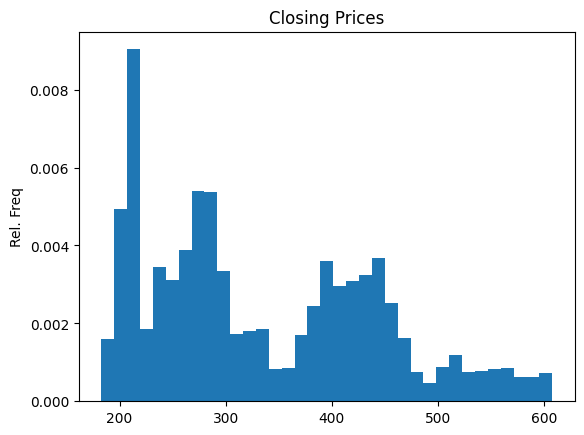

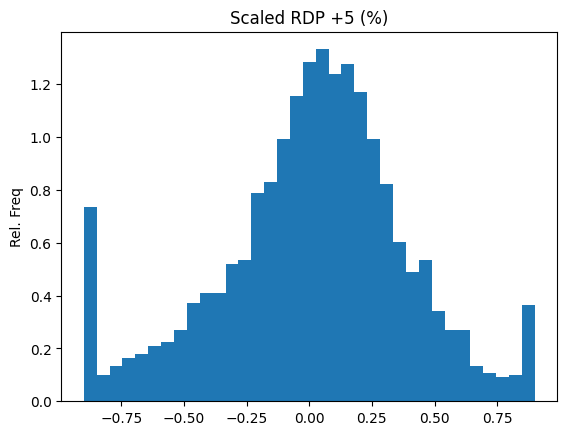

Iter 00  RMSE=0.4559
Iter 01  RMSE=0.4498
Iter 02  RMSE=0.4327
Iter 03  RMSE=0.4384
Iter 04  RMSE=0.4349
Iter 05  RMSE=0.4365
Iter 06  RMSE=0.4357
Iter 07  RMSE=0.4361
DS-1  RMSE = 0.4280
Iter 00  RMSE=0.4111
Iter 01  RMSE=0.3605
Iter 02  RMSE=0.3588
Iter 03  RMSE=0.3560
Iter 04  RMSE=0.3567
Iter 05  RMSE=0.3563
Iter 06  RMSE=0.3565
Iter 07  RMSE=0.3563
DS-2  RMSE = 0.3224
Iter 00  RMSE=0.4927
Iter 01  RMSE=0.4172
Iter 02  RMSE=0.4228
Iter 03  RMSE=0.4189
Iter 04  RMSE=0.4202
Iter 05  RMSE=0.4196
Iter 06  RMSE=0.4198
DS-3  RMSE = 0.4342
Iter 00  RMSE=0.3674
Iter 01  RMSE=0.3183
Iter 02  RMSE=0.3085
Iter 03  RMSE=0.3088
Iter 04  RMSE=0.3078
Iter 05  RMSE=0.3081
Iter 06  RMSE=0.3079
Iter 07  RMSE=0.3080
DS-4  RMSE = 0.4662
Summary RMSEs (DS‑I – DS‑IV)
          RMSE
Dataset       
DS-1    0.4280
DS-2    0.3224
DS-3    0.4342
DS-4    0.4662


In [19]:
# Run                                                                               
if __name__ == "__main__":                                                                                       
    df = load_spy_csv('SPY Closing Prices 1.1.15-12.31.24.csv')                
    close = df['Close']                                                                                              
    plot_histograms(close, bins=35)                                                                                         
    rmse_tbl = evaluate_walkforward(close, verbose=True)                                                                                     
    print("Summary RMSEs (DS‑I – DS‑IV)")                                       
    print(rmse_tbl.to_string(float_format=lambda x: f"{x:.4f}"))               